In [2]:
pip install prophet  scikeras tqdm cProfile pstats tensorflow sklearn -q

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cProfile (from versions: none)
ERROR: No matching distribution found for cProfile


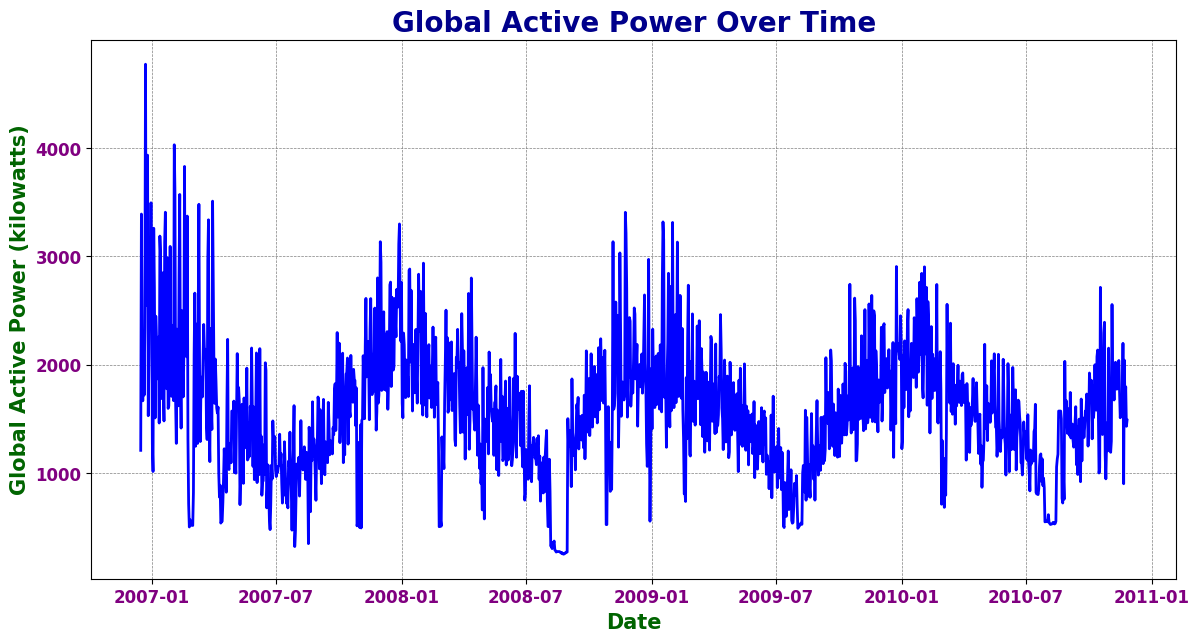

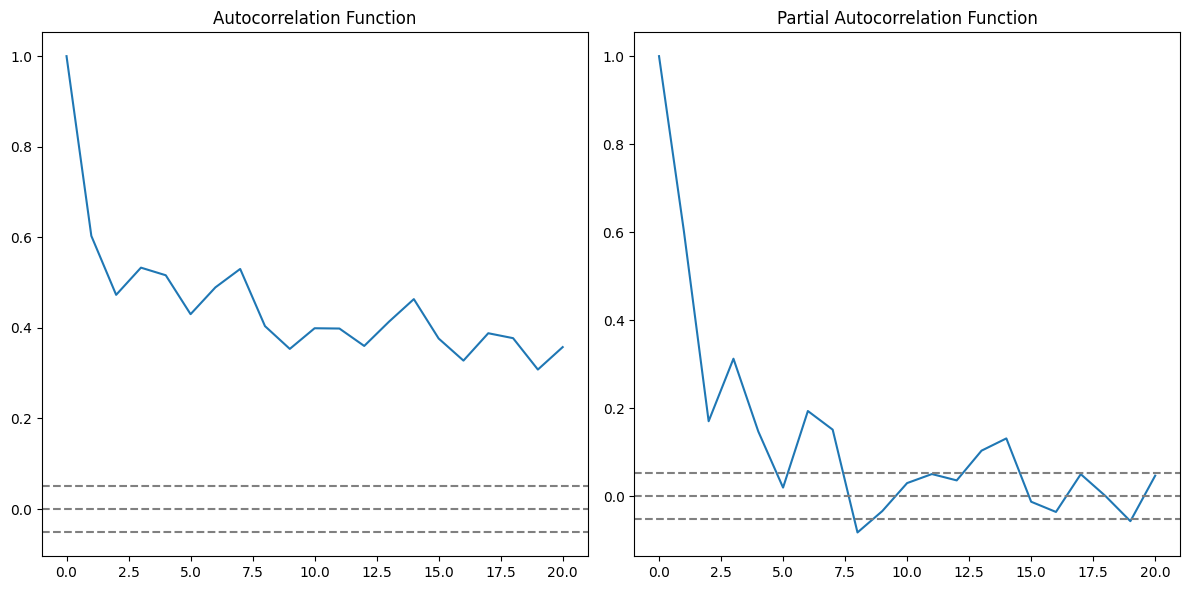

Training models:   0%|          | 0/10 [00:00<?, ?it/s]

00:38:46 - cmdstanpy - INFO - Chain [1] start processing
00:38:46 - cmdstanpy - INFO - Chain [1] done processing


Thu May 30 00:39:01 2024    profiling_results

         3167705 function calls (3022240 primitive calls) in 30.656 seconds

   Ordered by: cumulative time
   List reduced from 5421 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  2557/27    0.018    0.000   62.675    2.321 c:\Users\ALBER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\util\traceback_utils.py:138(error_handler)
      8/4    0.000    0.000   53.862   13.465 c:\Users\ALBER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\common\variables.py:80(__init__)
        3    0.000    0.000   53.838   17.946 c:\Users\ALBER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:455(add_weight)
    53/32    0.000    0.000   26.939    0.842 c:\Users\ALBER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\tree\tree_api.py:124(map_structure)
     12/2    0.000    0.000   26.931   1

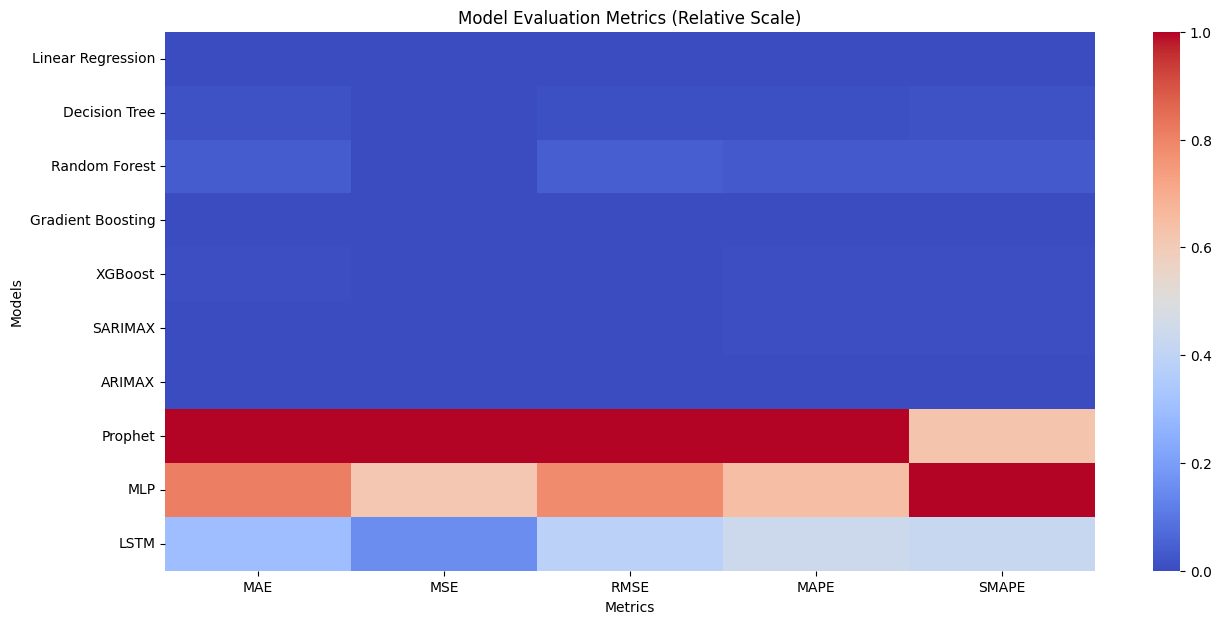

Best Model: Linear Regression Best Metrics: MAE        9.162135
MSE      255.504668
RMSE      15.984513
MAPE       0.654854
SMAPE      0.658334
Name: Linear Regression, dtype: object


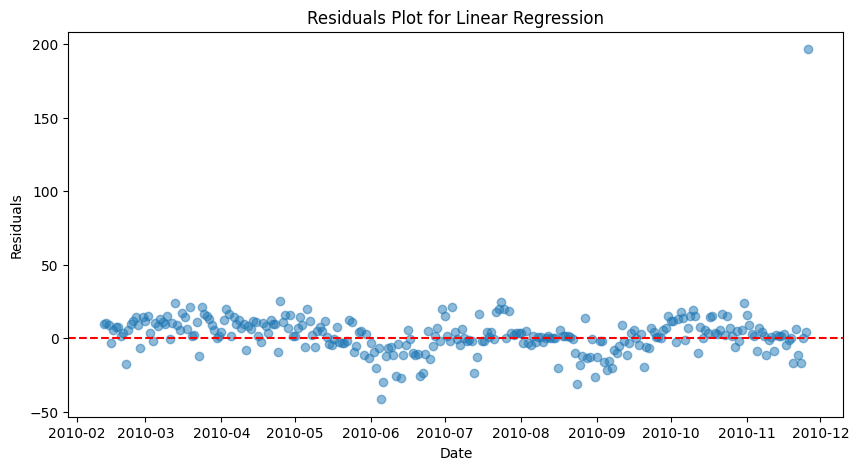

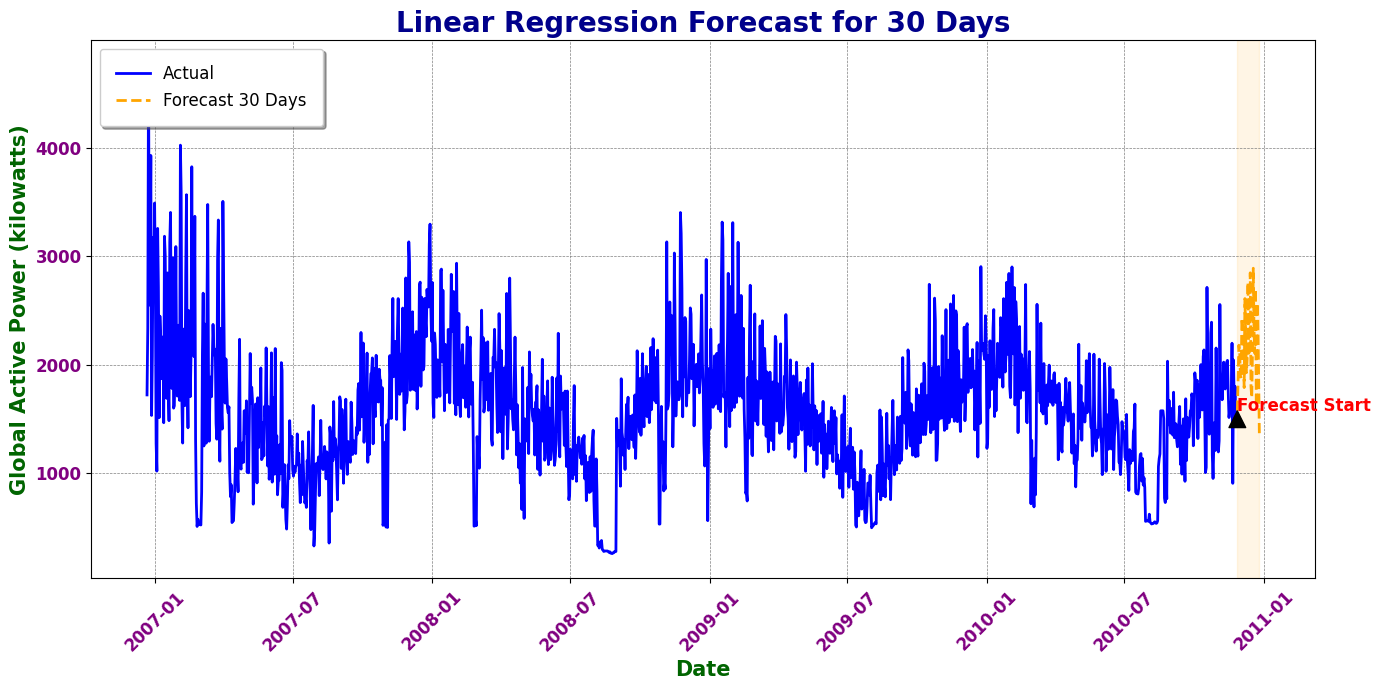

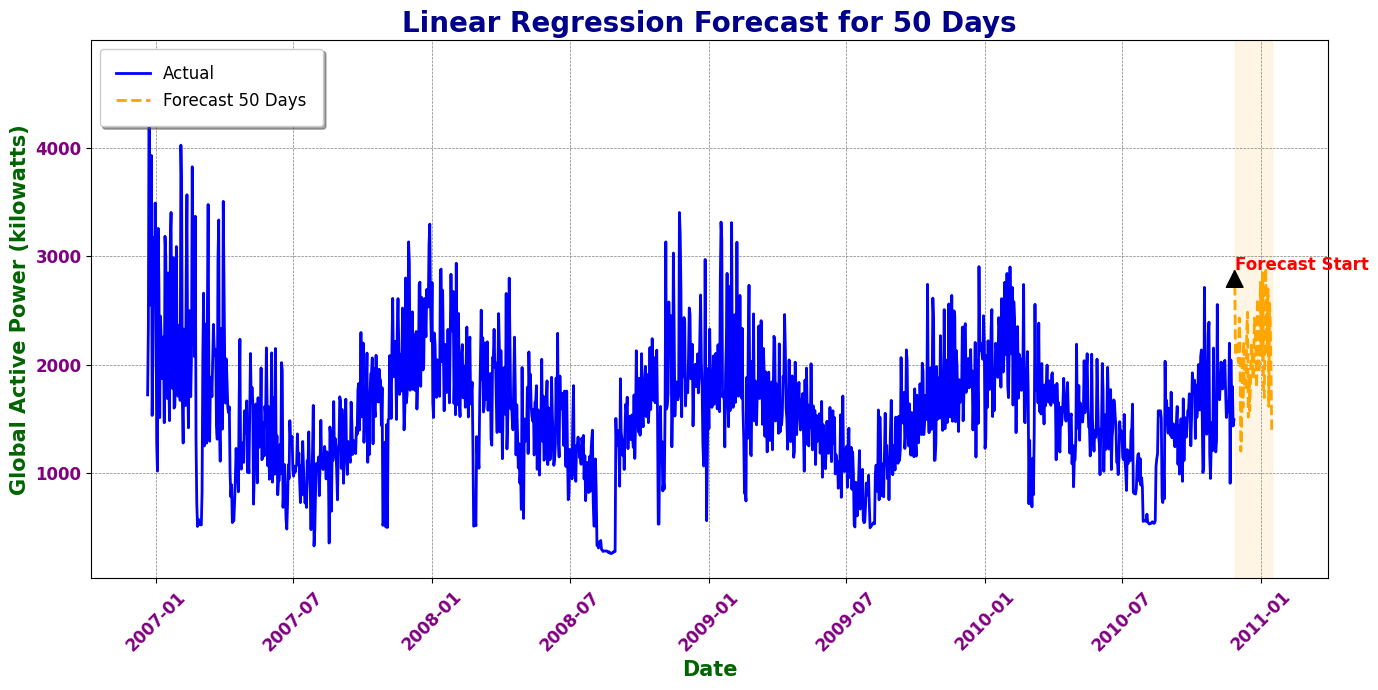

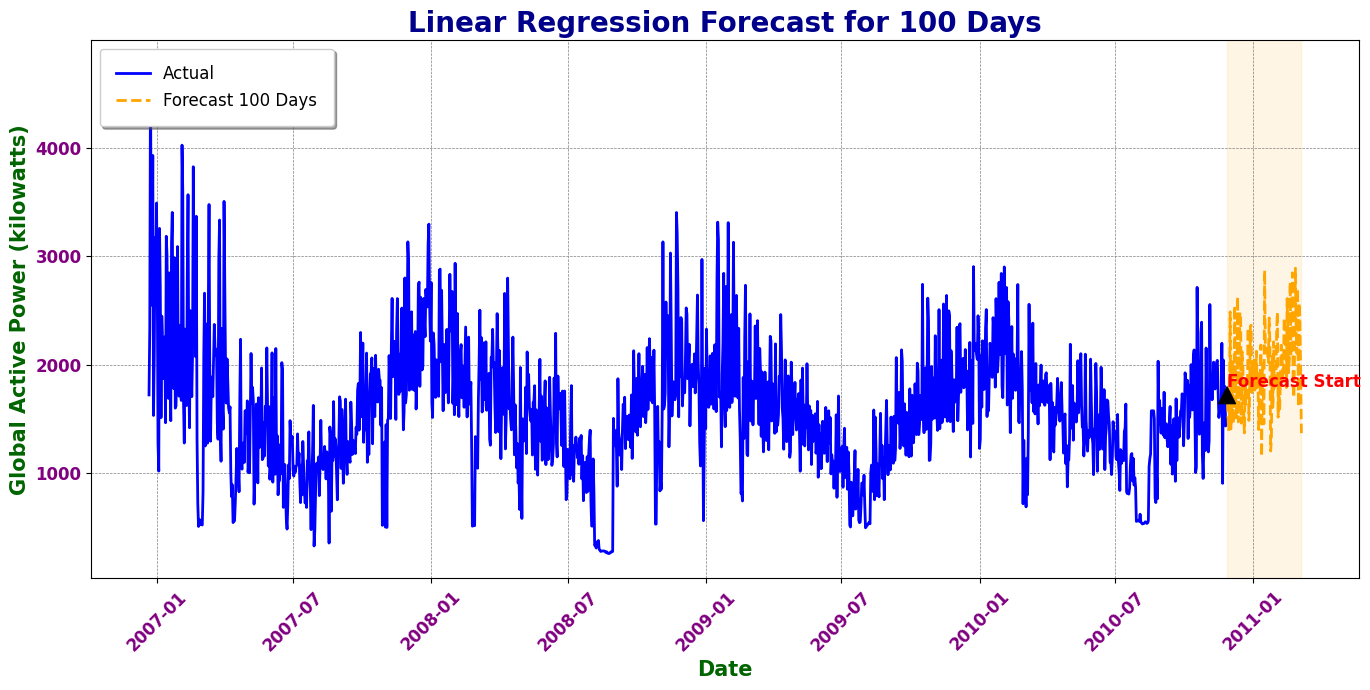

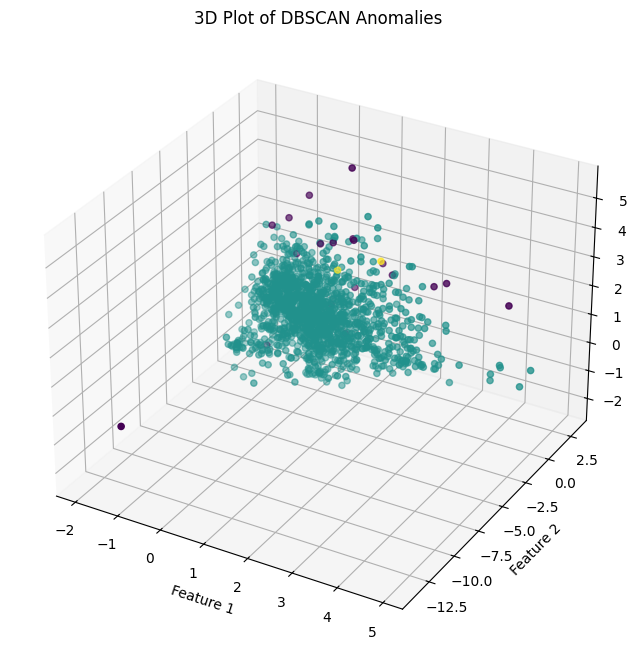

Number of anomalous points detected by Isolation Forest: 12
Number of anomalous points detected by DBSCAN: 19


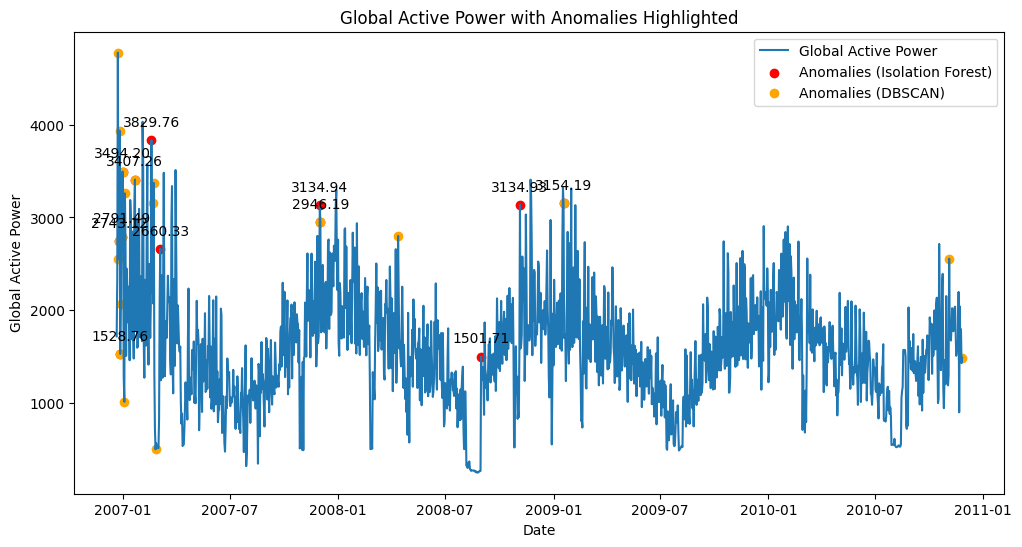

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
from tqdm.auto import tqdm
import warnings
import time
import cProfile
import pstats
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from statsmodels.tsa.stattools import acf, pacf

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 1: Load and preprocess data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
data = pd.read_csv(url, sep=';', parse_dates={'dt': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan', '?'], index_col='dt')
data.replace('?', np.nan, inplace=True)
data = data.astype(float)
data.fillna(data.mean(), inplace=True)

# Step 2: Resample data to daily consumption
daily_data = data.resample('D').sum()

# Plot Global_active_power over time
plt.figure(figsize=(14, 7))
plt.plot(daily_data.index, daily_data['Global_active_power'], color='blue', linestyle='-', linewidth=2)
plt.title('Global Active Power Over Time', fontsize=20, fontweight='bold', color='darkblue')
plt.xlabel('Date', fontsize=15, fontweight='bold', color='darkgreen')
plt.ylabel('Global Active Power (kilowatts)', fontsize=15, fontweight='bold', color='darkgreen')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, fontweight='bold', color='purple')
plt.yticks(fontsize=12, fontweight='bold', color='purple')
plt.show()

lag_acf = acf(daily_data['Global_active_power'], nlags=20)
lag_pacf = pacf(daily_data['Global_active_power'], nlags=20, method='ols')
# Plot ACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(daily_data['Global_active_power'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(daily_data['Global_active_power'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(daily_data['Global_active_power'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(daily_data['Global_active_power'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()
# Step 3: Feature engineering with lag variables
class LagFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_lags=5):
        self.n_lags = n_lags

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for i in range(1, self.n_lags + 1):
            X[f'lag_{i}'] = X['Global_active_power'].shift(i)
        return X.dropna()

# Step 4: Prepare data for machine learning
n_lags = 5
daily_data = LagFeatureTransformer(n_lags=n_lags).transform(daily_data)
X = daily_data.drop(['Global_active_power'], axis=1)
y = daily_data['Global_active_power']
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Custom wrappers for time series models (SARIMAX, ARIMAX, Prophet) and LSTM
# These wrappers are used to integrate these models into scikit-learn's workflow
class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_ = None
        self.date_index_ = None

    def fit(self, X, y):
        self.date_index_ = y.index
        self.model_ = SARIMAX(y, order=self.order, seasonal_order=self.seasonal_order, exog=X).fit(disp=False)
        return self

    def predict(self, X):
        future_index = pd.date_range(start=self.date_index_[-1] + pd.Timedelta(days=1), periods=len(X), freq='D')
        return self.model_.predict(start=future_index[0], end=future_index[-1], exog=X)

# Custom Wrapper for ARIMAX
class ARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_ = None
        self.date_index_ = None

    def fit(self, X, y):
        self.date_index_ = y.index
        self.model_ = SARIMAX(y, order=self.order, exog=X).fit(disp=False)
        return self

    def predict(self, X):
        future_index = pd.date_range(start=self.date_index_[-1] + pd.Timedelta(days=1), periods=len(X), freq='D')
        return self.model_.predict(start=future_index[0], end=future_index[-1], exog=X)

# Custom Wrapper for Prophet
class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, seasonality_mode='additive', yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto'):
        self.seasonality_mode = seasonality_mode
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.model_ = None
        self.date_index_ = None

    def fit(self, X, y):
        self.date_index_ = y.index
        df = pd.DataFrame({'ds': self.date_index_, 'y': y.values})
        self.model_ = Prophet(
            seasonality_mode=self.seasonality_mode,
            yearly_seasonality=self.yearly_seasonality,
            weekly_seasonality=self.weekly_seasonality,
            daily_seasonality=self.daily_seasonality
        )
        self.model_.fit(df)
        return self

    def predict(self, X):
        future = pd.DataFrame({'ds': pd.date_range(start=self.date_index_[-1] + pd.Timedelta(days=1), periods=len(X), freq='D')})
        forecast = self.model_.predict(future)
        return forecast['yhat'].values

# LSTM Model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

class LSTMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, epochs=50, batch_size=32):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model_ = None

    def fit(self, X, y):
        input_shape = (X.shape[1], X.shape[2])
        self.model_ = create_lstm_model(input_shape)
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model_.predict(X)

# Prepare data for LSTM and DeepAR
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X_lstm, y_lstm = create_sliding_window(daily_data['Global_active_power'].values, window_size)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))
train_size_lstm = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size_lstm], X_lstm[train_size_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:train_size_lstm], y_lstm[train_size_lstm:]

# Placeholder for DeepAR model integration
class DeepARWrapper(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        # Implement the training procedure for DeepAR here
        pass

    def predict(self, X):
        # Implement the prediction procedure for DeepAR here
        return np.zeros(len(X))  # Placeholder return

# Step 5: Define model pipelines with hyperparameter grids
model_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {'model__fit_intercept': [True, False]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [10, 50],
            'model__max_features': ['auto', 'sqrt']
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__subsample': [0.5, 0.7]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 5],
            'model__learning_rate': [0.01, 0.1]
        }
    },
    'SARIMAX': {
        'model': SARIMAXWrapper(),
        'params': {
            'model__order': [(1, 0, 0)],
            'model__seasonal_order': [(1, 1, 1, 2)]
        }
    },
    'ARIMAX': {
        'model': ARIMAXWrapper(),
        'params': {
            'model__order': [(2, 0, 0)]
        }
    },
    'Prophet': {
        'model': ProphetWrapper(),
        'params': {
            'model__seasonality_mode': ['additive', 'multiplicative'],
            'model__yearly_seasonality': [True, False],
            'model__weekly_seasonality': [True, False]
        }
    },
    'MLP': {
        'model': MLPRegressor(max_iter=500),
        'params': {
            'model__hidden_layer_sizes': [(50,), (100,)],
            'model__activation': ['relu', 'tanh'],
            'model__solver': ['adam'],
            'model__learning_rate': ['constant', 'adaptive']
        }
    },
    'LSTM': {
        'model': LSTMWrapper(),
        'params': {
            'epochs': [5, 10],
            'batch_size': [32, 64]
        }
    },
    # 'DeepAR': {
    #     'model': DeepARWrapper(),
    #     'params': {}  # Placeholder params
    # }  implement it !!!
}

# Step 6: Profile and train models using RandomizedSearchCV
def profile_and_train():
    optimized_models = {}
    for name, config in tqdm(model_params.items(), desc='Training models'):
        if name in ['LSTM', 'DeepAR']:
            # LSTM and DeepAR require different data
            if name == 'LSTM':
                search = RandomizedSearchCV(config['model'], config['params'], n_iter=2, cv=2, verbose=0, random_state=42, n_jobs=-1)
                search.fit(X_train_lstm, y_train_lstm)
            elif name == 'DeepAR':
                model = config['model']
                model.fit(X_train_lstm, y_train_lstm)
                search = model  # Placeholder
            optimized_models[name] = search
        else:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', config['model'])
            ])
            search = RandomizedSearchCV(pipeline, config['params'], n_iter=2, cv=2, verbose=0, random_state=42, n_jobs=-1)
            search.fit(X_train, y_train)
            optimized_models[name] = search.best_estimator_
    return optimized_models

cProfile.run('optimized_models = profile_and_train()', 'profiling_results')

# Print profiling results
p = pstats.Stats('profiling_results')
p.sort_stats('cumulative').print_stats(10)

# Define evaluation metrics functions
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

def evaluate_model(model, X_test, y_test, model_name=None):
    if model_name in ['LSTM', 'DeepAR']:
        predictions = model.predict(X_test)
    else:
        predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, predictions)
    smape = symmetric_mean_absolute_percentage_error(y_test, predictions)
    return mae, mse, rmse, mape, smape, predictions

# Evaluate all models and store the results
results = {}
for name, model in optimized_models.items():
    if name in ['LSTM', 'DeepAR']:
        mae, mse, rmse, mape, smape, predictions = evaluate_model(model, X_test_lstm, y_test_lstm, model_name=name)
    else:
        mae, mse, rmse, mape, smape, predictions = evaluate_model(model, X_test, y_test)
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
        'Predictions': predictions
    }

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T

# Normalize the results for each metric to use a relative scale
normalized_results_df = results_df.drop(columns='Predictions').apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Plot the evaluation grid with relative scaling
plt.figure(figsize=(15, 7))
sns.heatmap(normalized_results_df.astype(float), annot=False, cmap='coolwarm', xticklabels=normalized_results_df.columns, yticklabels=normalized_results_df.index)
plt.title('Model Evaluation Metrics (Relative Scale)')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()

results_df['MSE'] = pd.to_numeric(results_df['MSE'], errors='coerce')

# Drop any rows where 'MSE' is NaN
results_df = results_df.dropna(subset=['MSE'])

# Identify the best model based on MSE
best_model_name = results_df['MSE'].idxmin()
best_model_metrics = results_df.loc[best_model_name].drop('Predictions')

print("Best Model:", best_model_name, "Best Metrics:", best_model_metrics)

# Identify the best model based on MSE
best_model_name = results_df['MSE'].idxmin()
best_model_predictions = results[best_model_name]['Predictions']
# Plot metrics for the best model
# plt.figure(figsize=(10, 5))
# best_model_metrics.plot(kind='bar', color='skyblue')
# plt.title(f'Metrics for Best Model: {best_model_name}')
# plt.xlabel('Metrics')
# plt.ylabel('Values')
# plt.xticks(rotation=45)
# plt.show()



# Plot residual errors for the best model
residuals = y_test - best_model_predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test.index, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residuals Plot for {best_model_name}')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()


# Forecasting future data using the best model
def forecast_future(model, X_train, horizon):
    if best_model_name in ['LSTM', 'DeepAR']:
        X_train_windowed = X_train[-window_size:].reshape(1, window_size, 1)
        predictions = []
        for _ in range(horizon):
            pred = model.predict(X_train_windowed)
            predictions.append(pred[0, 0])
            X_train_windowed = np.append(X_train_windowed[:, 1:, :], pred.reshape(1, 1, 1), axis=1)
        return np.array(predictions)
    elif best_model_name == 'Prophet':
        future = pd.date_range(start=X_train.index[-1] + pd.Timedelta(days=1), periods=horizon, freq='D')
        future_df = pd.DataFrame({'ds': future})
        forecast = model.model_.predict(future_df)
        return forecast['yhat'].values
    else:
        X_train_ext = X_train[-horizon:]
        return model.predict(X_train_ext)

horizons = [30, 50, 100]
for horizon in horizons:
    forecasted_values = forecast_future(optimized_models[best_model_name], X_train, horizon)
    future_dates = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=horizon, freq='D')
    
    
    plt.figure(figsize=(14, 7))
    
    # Plot actual values
    plt.plot(y.index, y, label='Actual', color='blue', linestyle='-', linewidth=2)
    
    # Plot forecasted values
    plt.plot(future_dates, forecasted_values, label=f'Forecast {horizon} Days', linestyle='--', color='orange', linewidth=2)
    
    # Adding title and labels
    plt.title(f'{best_model_name} Forecast for {horizon} Days', fontsize=20, fontweight='bold', color='darkblue')
    plt.xlabel('Date', fontsize=15, fontweight='bold', color='darkgreen')
    plt.ylabel('Global Active Power (kilowatts)', fontsize=15, fontweight='bold', color='darkgreen')
    
    # Adding grid
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    # Customizing ticks
    plt.xticks(fontsize=12, fontweight='bold', color='purple', rotation=45)
    plt.yticks(fontsize=12, fontweight='bold', color='purple')
    
    # Adding legend
    plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, borderpad=1)
    
    # Adding a shaded area for the forecast period
    plt.axvspan(future_dates[0], future_dates[-1], color='orange', alpha=0.1)
    
    # Annotating the start of the forecast
    plt.annotate('Forecast Start', xy=(future_dates[0], forecasted_values[0]), 
                 xytext=(future_dates[0], forecasted_values[0] + 0.1), 
                 arrowprops=dict(facecolor='black', shrink=0.05), 
                 fontsize=12, fontweight='bold', color='red')
    
    plt.tight_layout()
    plt.show()





# Anomaly Detection with Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)
anomalies_iso_forest = iso_forest.predict(X)
anomalous_points_iso_forest = X[anomalies_iso_forest == -1]

# Anomaly Detection with DBSCAN
dbscan = DBSCAN(eps=3, min_samples=2)
X_scaled = StandardScaler().fit_transform(X)
dbscan.fit(X_scaled)
anomalies_dbscan = dbscan.labels_
anomalous_points_dbscan = X[anomalies_dbscan == -1]

# Plotting 3D representation of DBSCAN results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=anomalies_dbscan, cmap='viridis')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Plot of DBSCAN Anomalies')
plt.show()

# Printing number of time series with anomalous patterns
num_anomalous_iso_forest = len(anomalous_points_iso_forest)
num_anomalous_dbscan = len(anomalous_points_dbscan)
print(f'Number of anomalous points detected by Isolation Forest: {num_anomalous_iso_forest}')
print(f'Number of anomalous points detected by DBSCAN: {num_anomalous_dbscan}')

# Plotting one variable time series highlighting points of anomaly
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Global Active Power')
plt.scatter(anomalous_points_iso_forest.index, y.loc[anomalous_points_iso_forest.index], color='red', label='Anomalies (Isolation Forest)')
plt.scatter(anomalous_points_dbscan.index, y.loc[anomalous_points_dbscan.index], color='orange', label='Anomalies (DBSCAN)')
for idx in anomalous_points_iso_forest.index:
    plt.annotate(f'{y.loc[idx]:.2f}', (idx, y.loc[idx]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Global Active Power with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()